In [1]:
# STEINMETZ PREPROCESSING

In [2]:
# Set up

# Import packages
import os, requests
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd

# Download and load data 
from data.get_data import load,download

download()


# Load data
alldat = load()


Loading data. Patience, padawan ...


In [3]:
# Load data

alldat = load()

Loading data. Patience, padawan ...


In [34]:
# Basic information about Steinmetz dataset: descriptive for each session
session = []
mouse_name = []
number_trials = []
total_trials = 0
for i in range(len(alldat)):
    dat = alldat[i]
    session.append(i+1)
    mouse_name.append(dat.get('mouse_name'))
    number_trials.append(len(dat.get('gocue')))
    total_trials += len(dat.get('gocue'))
    
first_dict = {'Session': session, 'Mouse Name': mouse_name, 'Number of Trials': number_trials}
basic_data_info = pd.DataFrame(first_dict, columns=['Session', 'Mouse Name','Number of Trials'])

print(basic_data_info)
print('Total number of trials: ', total_trials)

    Session Mouse Name  Number of Trials
0         1       Cori               214
1         2       Cori               251
2         3       Cori               228
3         4  Forssmann               249
4         5  Forssmann               254
5         6  Forssmann               290
6         7  Forssmann               252
7         8      Hench               250
8         9      Hench               372
9        10      Hench               447
10       11      Hench               342
11       12  Lederberg               340
12       13  Lederberg               300
13       14  Lederberg               268
14       15  Lederberg               404
15       16  Lederberg               280
16       17  Lederberg               224
17       18  Lederberg               316
18       19      Moniz               247
19       20      Moniz               235
20       21      Moniz               124
21       22     Muller               444
22       23     Muller               151
23       24     

In [41]:
#DataFrame for EVERY-SINGLE-TRIAL *clap emoji* (excluding passive trials: just Go (left/right) or NoGo trials)

s = 0
test_sessions = [1, 4, 8, 12, 19, 22, 25, 30, 35]

# Initialize empty list 
session = [] 
session_type = []
mouse_name = []  
trial_number = []
go_trial = []   #either TRUE (Go trial) or FALSE(= NoGo trial)
trial_type = []  # A, B, C, D, or E
stim_loc = []   # 
ideal_resp = []
gocue = [] #dat['gocue']: when the go cue sound was played. 
response_time = []
latency = []
mouse_resp = []
wheel_velocity = []
wheel_acceleration = []
pres_acc = []
feedback_onset = []
feedback_type = []
contrast_left = []
contrast_right = []
contrast_diff = []
pres_difficulty = []

# Loop to fill all lists with data from Steinmetz dataset
for dat in alldat:
    s += 1
    for t in range(len(dat.get('gocue'))):      #just because the length of this field = number of trials for a given session
        # session #
        session.append(s)        #session number

        if session[t] == 1 or session[t] == 4 or session[t] == 8 or session[t] == 12 or session[t] == 19 or session[t] == 22 or session[t] == 25 or session[t] == 30 or session[t] == 35:
            session_type.append('test')
        else: 
            session_type.append('train') 
        
        # mouse name
        mouse_name.append(dat.get('mouse_name')) #you know... just the name of the little fellow
        
        # trial number
        trial_number.append(t+1)      #trial number for that particular session

        # whether it was a go trial or not
        go_trial.append((dat.get('contrast_left')[t] != 0) or (dat.get('contrast_right')[t] != 0))
        
        # trial type, stimulus location on pres trial, and ideal response
        if dat.get('contrast_left')[t] == 0 and dat.get('contrast_right')[t] != 0:
            trial_t = 'A'
            stim_l = -1
            ideal_r = -1
        elif dat.get('contrast_left')[t] != 0 and dat.get('contrast_right')[t] == 0:
            trial_t = 'B'
            stim_l = 1
            ideal_r = 1
        elif dat.get('contrast_right')[t] and dat.get('contrast_left')[t] != 0 and dat.get('contrast_right')[t] > dat.get('contrast_left')[t] :
            trial_t = 'C'
            stim_l = 2
            ideal_r = -1
        elif dat.get('contrast_right')[t] and dat.get('contrast_left')[t]  != 0 and dat.get('contrast_right')[t] < dat.get('contrast_left')[t] :
            trial_t = 'D'
            stim_l= 2
            ideal_r = 1
        elif dat.get('contrast_left')[t]  == 0 and dat.get('contrast_right')[t] == 0:
            trial_t= 'E'
            stim_l = 0
            ideal_r = 0
        else:
            trial_t = np.nan
            stim_l = np.nan
            ideal_r = np.nan
            
        trial_type.append(trial_t) 
        stim_loc.append(stim_l)
        ideal_resp.append(ideal_r)
        
        # go cue onset
        gocue.append(dat.get('gocue')[t][0]*1000) #the sencond index value is just there so that we can directly access floats from the DF
        
        # mouse response time 
        response_time.append(dat.get('response_time')[t][0]*1000)
        
        # latency (how long it took mouse to respond after go cue (i.e. RT - go cue))
        latency.append(float((dat.get('response_time')[t][0])-(dat.get('gocue')[t][0]))*1000)
        
        # append mouse's response
        mouse_resp.append(dat.get('response')[t])
        
#         # velocity
#         wheel_velocity.append(dat['wheel'][0][0]) 
        
#         # wheel acceleration
#         wheel_acceleration.append(np.diff(vel[t]/10))
        
        # mouse's accuracy on present trial
        if ideal_resp[t] == mouse_resp[t]: 
            mouse_acc_binary = 1.
            pres_acc.append(mouse_acc_binary)
        else:
            mouse_acc_binary = 0.
            pres_acc.append(mouse_acc_binary)
    
        # feedback onset 
        feedback_onset.append((dat.get('feedback_time')[t][0]*1000))
        
        # feedback type 
        feedback_type.append(dat.get('feedback_type')[t]) #feedback type: positive (+1) means reward, negative (-1) means white noise burst 
       
        # stimulus contrasts and differences between them
        contrast_left.append(dat.get('contrast_left')[t])
        contrast_right.append(dat.get('contrast_right')[t])
        
        if stim_loc[t] != 0:
            contrast_diff.append((dat.get('contrast_left')[t] - dat.get('contrast_right')[t]).astype(float))
        else:
            contrast_diff.append(np.nan)

        # present difficulty
        if (dat.get('contrast_left')[t] != 0) or (dat.get('contrast_right')[t] != 0):
            pres_difficulty.append(1-np.abs(dat.get('contrast_left')[t]-dat.get('contrast_right')[t]))
        else:
            pres_difficulty.append(np.nan)


In [43]:
dict = {'session': session, 
        'session_type': session_type,
        'mouse_name': mouse_name, 
        'trial_number': trial_number,
        'trial_type': trial_type,
        'go_trial': go_trial,
        'stim_loc': stim_loc,
        'ideal_resp': ideal_resp,
        'response_time': response_time,
        'latency': latency,
        'mouse_resp': mouse_resp,
#         'wheel_velocity': wheel_velocity,
#         'wheel_acceleration': wheel_acceleration,
        'pres_acc': pres_acc,
        'feedback_onset': feedback_onset,
        'feedback_type': feedback_type,
        'contrast_left': contrast_left,
        'contrast_right': contrast_right,
        'contrast_diff': contrast_diff,
        'pres_difficulty': pres_difficulty
       }

data_extracted = pd.DataFrame(dict)
data_extracted.head()

,session,session_type,mouse_name,trial_number,trial_type,go_trial,stim_loc,ideal_resp,response_time,latency,mouse_resp,pres_acc,feedback_onset,feedback_type,contrast_left,contrast_right,contrast_diff,pres_difficulty
0,1,test,Cori,1,B,True,1.0,1.0,1150.203633,122.987383,1.0,1.0,1186.818795,1.0,1.0,0.0,1.0,0.0
1,1,test,Cori,2,A,True,-1.0,-1.0,1399.502868,525.089054,-1.0,1.0,1437.622794,1.0,0.0,0.5,-0.5,0.5
2,1,test,Cori,3,D,True,2.0,1.0,949.291045,124.078016,1.0,1.0,986.015593,1.0,1.0,0.5,0.5,0.5
3,1,test,Cori,4,E,False,0.0,0.0,2266.801672,1505.189657,0.0,1.0,2296.436486,1.0,0.0,0.0,NaN,NaN
4,1,test,Cori,5,C,True,2.0,-1.0,816.775837,154.765410,1.0,0.0,827.613068,-1.0,0.5,1.0,-0.5,0.5


In [ ]:
 # velocity
wheel_velocity.append(dat['wheel'][0][0]) 
        
# wheel acceleration
wheel_acceleration.append(np.diff(vel[t]/10))

[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.
  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  2.  4.  7.  8. 12. 14. 16.
 17. 17. 16. 16. 13. 12. 10.  7.  4.  2.  1.  1.  3.  5.  8. 12. 15. 18.
 18. 19. 19. 17. 16. 14. 12. 10.  8.  6.  6.  5.  6.  8. 10. 11. 11. 12.
 13. 12. 12. 11. 10.  9.  6.  5.  3.  4.  4.  5.  6.  5.  7.  7.  8.  9.
 10. 11. 13. 13. 14. 14. 15. 14. 13. 12.  9.  7.  4.  4.  2.  2.  3.  4.
  7. 10. 14. 17. 18. 18. 18. 18. 17. 15. 13. 10.  8.  7.  6.  6.  6.  7.
  8.  9. 10. 11. 11. 13. 13. 12. 10. 10.  8.  7.  5.  3.  2.  1.  0. -1.
 -1. -1. -1.  0.  0.  1.  1.  2.  2.  3.  2.  1.  1. -1. -2. -4. -3. -3.
 -3. -2. -1.  0.  1.  1.  2.  0. -1. -2. -4. -3. -2. -1.  0.  2.  2.  2.
  2.  1.  1.  1.  0.  1.  1.  2.  1.  2.  2.  1.  1.  0.  0. -1. -1. -1.
  0.  1.  0.  1.  1.  1.  0.  0. -1. -1. -1.  0.  0

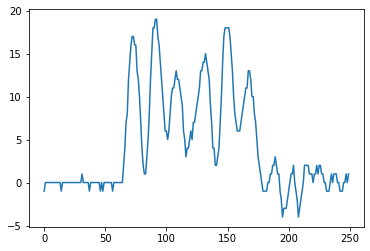

In [40]:
plt.plot(data_extracted['wheel_velocity'][0])
# plt.plot(data_extracted['wheel_acceleration'][0], color = 'r')

print(data_extracted['wheel_velocity'][0])
print(dat['wheel'][0][0])

(1, 343, 250)


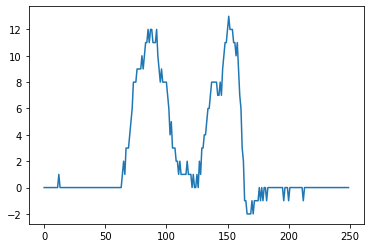

In [32]:
s = 0
plt.plot(dat['wheel'][0][0])

print(dat['wheel'].shape)

In [33]:
dat['wheel'].shape


(1, 343, 250)

In [10]:
# Get previous accuracy and previous difficulty 

# Get previous difficulty
empty = np.empty([len(data_extracted['mouse_resp']), 1])
empty[0] = 'NaN' #ignore first index because there is no previous trial to this index

for i in range(len(empty)-1):
    empty[i+1] = data_extracted['pres_difficulty'][i]

prev_difficulty = pd.DataFrame(empty)
prev_difficulty = prev_difficulty.rename(columns={0: 'prev_difficulty'})

# Get previous accuracy
empty = np.empty([len(data_extracted['mouse_resp']), 1])
empty[0] = 'NaN' #ignore first index because there is no previous trial to this index

for i in range(len(empty)-1):
    empty[i+1] = data_extracted['pres_acc'][i]

prev_acc = pd.DataFrame(empty)
prev_acc = prev_acc.rename(columns={0: 'prev_acc'})

# Combine into one df
prevs = pd.concat([prev_difficulty, prev_acc], axis = 1)

prevs.shape

(10050, 2)

In [11]:
# Combine everything into one DF
data_extracted_unified = pd.concat([data_extracted, prevs], axis = 1)

# Make sure all dfs are the same length (i.e. have the same number of rows)

if len(data_extracted) == len(prevs) == len(data_extracted_unified):
    print('length of all dfs match! woo you are in the clear')

data_extracted_unified.columns

length of all dfs match! woo you are in the clear


Index(['session', 'session_type', 'mouse_name', 'trial_number', 'trial_type',
       'go_trial', 'stim_loc', 'ideal_resp', 'response_time', 'latency',
       'mouse_resp', 'wheel_velocity', 'wheel_acceleration', 'pres_acc',
       'feedback_onset', 'feedback_type', 'contrast_left', 'contrast_right',
       'contrast_diff', 'pres_difficulty', 'prev_difficulty', 'prev_acc'],
      dtype='object')

In [12]:
print('column: "session", dtype:', data_extracted_unified['session'].dtype)
print('column: "session_type", dtype:', data_extracted_unified['session_type'].dtype)
print('column: "mouse_name", dtype:', data_extracted_unified['mouse_name'].dtype)
print('column: "trial_number", dtype:', data_extracted_unified['trial_number'].dtype)
print('column: "trial_type", dtype:', data_extracted_unified['trial_type'].dtype)
print('column: "go_trial", dtype:', data_extracted_unified['go_trial'].dtype)
print('column: "stim_loc", dtype:', data_extracted_unified['stim_loc'].dtype)
print('column: "ideal_resp", dtype:', data_extracted_unified['ideal_resp'].dtype)
print('column: "gocue", dtype:', data_extracted_unified['gocue'].dtype)
print('column: "response_time", dtype:', data_extracted_unified['response_time'].dtype)
print('column: "latency", dtype:', data_extracted_unified['latency'].dtype)
print('column: "mouse_resp", dtype:', data_extracted_unified['mouse_resp'].dtype)
print('column: "wheel_go_rt", dtype:', data_extracted_unified['wheel_go_rt'].dtype)
print('column: "wheel_stim_rt", dtype:', data_extracted_unified['wheel_stim_rt'].dtype)
print('column: "pres_acc", dtype:', data_extracted_unified['pres_acc'].dtype)
print('column: "feedback_onset", dtype:', data_extracted_unified['feedback_onset'].dtype)
print('column: "feedback_type", dtype:', data_extracted_unified['feedback_type'].dtype)
print('column: "contrast_left", dtype:', data_extracted_unified['contrast_left'].dtype)
print('column: "contrast_right", dtype:', data_extracted_unified['contrast_right'].dtype)
print('column: "contrast_diff", dtype:', data_extracted_unified['contrast_diff'].dtype)
print('column: "pres_difficulty", dtype:', data_extracted_unified['pres_difficulty'].dtype)
print('column: "prev_difficulty", dtype:', data_extracted_unified['prev_difficulty'].dtype)
print('column: "prev_acc", dtype:', data_extracted_unified['prev_acc'].dtype)

column: "session", dtype: int64
column: "session_type", dtype: object
column: "mouse_name", dtype: object
column: "trial_number", dtype: int64
column: "trial_type", dtype: object
column: "go_trial", dtype: bool
column: "stim_loc", dtype: float64
column: "ideal_resp", dtype: float64


KeyError: 'gocue'

In [ ]:
print(data_extracted_unified['contrast_diff'])

In [ ]:
data_extracted_unified['trial_number'] = 